In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as web
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

C:\Users\ADMIN\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
df6012 = web.DataReader('6012.KL', data_source='yahoo', start='2010-05-01',end='2020-05-01')

In [3]:
df6012['Difference'] = df6012['Open'] - df6012['Close']
df6012.head()

,High,Low,Open,Close,Volume,Adj Close,Difference
Date,,,,,,,
2010-05-03,5.32,5.30,5.30,5.32,2204400.0,3.305936,-0.02
2010-05-04,5.33,5.30,5.32,5.30,2266000.0,3.293509,0.02
2010-05-05,5.31,5.28,5.29,5.31,5072800.0,3.299722,-0.02
2010-05-06,5.31,5.27,5.28,5.31,7349400.0,3.299722,-0.03
2010-05-07,5.29,5.24,5.28,5.26,9684200.0,3.268651,0.02


In [4]:
df6012.tail()

,High,Low,Open,Close,Volume,Adj Close,Difference
Date,,,,,,,
2020-03-06,5.45,5.36,5.37,5.43,1813100.0,5.43,-0.06
2020-03-09,5.46,5.30,5.38,5.31,3013200.0,5.31,0.07
2020-03-10,5.37,5.25,5.29,5.25,3148600.0,5.25,0.04
2020-03-11,5.31,5.21,5.27,5.27,3875400.0,5.27,0.00
2020-03-12,5.31,5.20,5.25,5.25,2038200.0,5.25,0.00


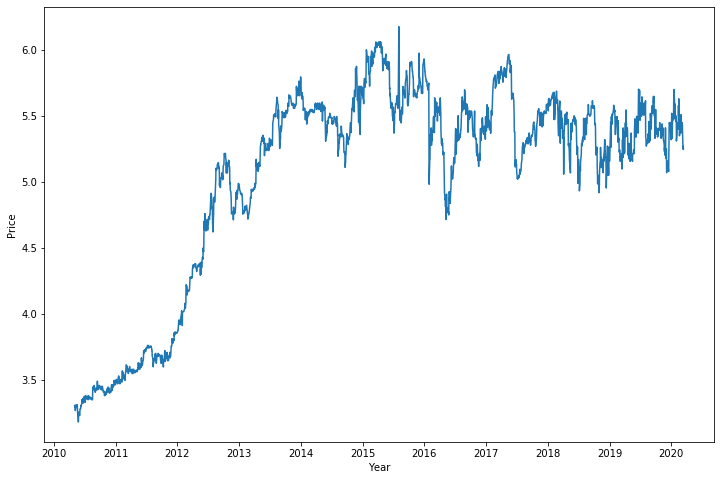

In [5]:
plt.figure(figsize = (12,8))
plt.plot(df6012['Adj Close'])
plt.xlabel("Year")
plt.ylabel("Price")
plt.show()

In [6]:
df6012.to_csv('maxis.csv')

In [6]:
dfPre = []
dfPre = df6012[['Adj Close']]

In [8]:
print(dfPre.head())

            Adj Close
Date                 
2010-05-03   3.305936
2010-05-04   3.293509
2010-05-05   3.299722
2010-05-06   3.299722
2010-05-07   3.268651


In [10]:
forecast_out = 30 #predict n days into the future, in this case, 30
dfPre['Prediction'] = dfPre[['Adj Close']].shift(-forecast_out)
print(dfPre.head())

            Adj Close  Prediction
Date                             
2010-05-03   3.305936    3.350196
2010-05-04   3.293509    3.343888
2010-05-05   3.299722    3.343888
2010-05-06   3.299722    3.350196
2010-05-07   3.268651    3.356505


C:\Users\ADMIN\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
X = np.array(dfPre.drop(['Prediction'], 1))
len(X)

2437

In [12]:
#reserving 60 data for testing
X_new = X[0:2377]
len(X_new) + 60

2437

In [15]:
X_new[0:10]

array([[3.3059361 ],
       [3.29350901],
       [3.29972196],
       [3.29972196],
       [3.26865149],
       [3.29350901],
       [3.31215048],
       [3.31215048],
       [3.31215048],
       [3.31215048]])

In [16]:
y = np.array(dfPre['Prediction'])
y_new = y[:-60]
len(y_new)

2377

In [17]:
y_new[0:10]

array([3.35019565, 3.34388781, 3.34388781, 3.35019565, 3.35650492,
       3.32495856, 3.35650492, 3.3628509 , 3.35650444, 3.35016036])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size = 0.2)

In [21]:
y = np.array(dfPre['Prediction'])
y = y[:-forecast_out]
print(y)
len(y)

[3.35019565 3.34388781 3.34388781 ... 5.25       5.26999998 5.25      ]


2407

In [22]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [23]:
y_pre = lr.predict(X[2407:2437])
print("Predicted last 30 days")
print(y_pre)

Predicted last 30 days
[5.31460604 5.36094345 5.43508296 5.43508296 5.39801321 5.44435018
 5.40728042 5.39801321 5.5648271  5.49068759 5.61116452 5.47215272
 5.35167579 5.37021067 5.39801321 5.43508296 5.38874555 5.44435018
 5.37021067 5.49995525 5.4258153  5.44435018 5.37947833 5.44435018
 5.37947833 5.4258153  5.31460604 5.2590014  5.27753628 5.2590014 ]


In [25]:
confidence = lr.score(X_test, y_test)
print("Confidence Score: ", confidence)

Confidence Score:  0.9215180447100499


In [27]:
x_forecast = np.array(dfPre.drop(['Prediction'], 1))[-forcast_out:]
print("Actual last 30 days: ")
print(x_forecast)

Actual last 30 days: 
[[5.30999994]
 [5.36000013]
 [5.44000006]
 [5.44000006]
 [5.4000001 ]
 [5.44999981]
 [5.40999985]
 [5.4000001 ]
 [5.57999992]
 [5.5       ]
 [5.63000011]
 [5.48000002]
 [5.3499999 ]
 [5.36999989]
 [5.4000001 ]
 [5.44000006]
 [5.38999987]
 [5.44999981]
 [5.36999989]
 [5.51000023]
 [5.42999983]
 [5.44999981]
 [5.38000011]
 [5.44999981]
 [5.38000011]
 [5.42999983]
 [5.30999994]
 [5.25      ]
 [5.26999998]
 [5.25      ]]


Text(0, 0.5, 'Price')

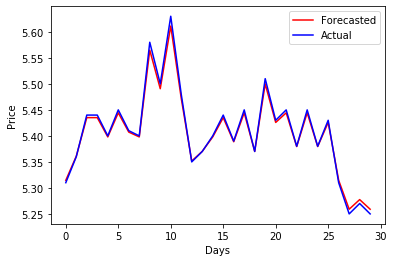

In [28]:
plt.plot(y_pre, color='r')
plt.plot(x_forecast, color='b')
plt.legend(['Forecasted', 'Actual'])
plt.xlabel("Days")
plt.ylabel("Price")